In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
font = {'family' : 'nomal',
            'weight' : 'normal',
            'size'   : 14}
mpl.rc('font', **font)

In [2]:
df = pd.read_csv('../data/qm9-shape-properties', sep=' ', 
    names='dbid dipole polarizability homo lumo gap extent zpve internalzero internalfinite enthalpy freeenergy heatcap volume area'.split())

/home/guido/miniconda3/envs/analysis/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['nomal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


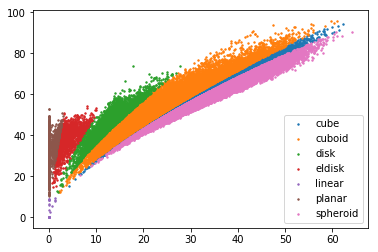

In [5]:
df['shape'] = df.apply(lambda row: classify(row.volume, row.area), axis=1)
for name, group in df.groupby('shape'):
    plt.scatter(group.volume, group.area, s=2, label=name)
plt.legend()

In [4]:
def classify(volume, area):    
    def spheroid(xs, ratio):
        e = 1-1/ratio**2
        return 2*np.pi*(3*xs/(4*np.pi*ratio))**(2/3)*(1+ratio/np.sqrt(e) * np.arcsin(np.sqrt(e)))

    def cuboid(xs, px, py):
        return 2*(px+py+px*py)*(xs/(px*py))**(2/3)

    def disk(xs, ratio):
        return 2*np.pi*(xs*ratio/np.pi)**(2/3)*(1+1/ratio)

    def vertical(xs, limit):
        return [0] + [limit] * (len(xs)-1)

    def eldisk(xs, px, py):
        h = (1-px)**2/(1+px)**2
        q = 2*np.pi*px + py*np.pi*(1+px)*(1+3*h/(10+np.sqrt(4-3*h)))
        return (xs/(np.pi*px*py))**(2/3)*q
    
    def sphere(xs):
        return (6*xs)**(2/3)*(np.pi)**(1/3)
    
    def cube(xs):
        return 6*(xs)**(2/3)
    
    if volume < 10 and area < 10:
        return 'linear'
    
    borders = np.array([eldisk(volume, 25, 0.2),eldisk(volume, 8, 0.2), eldisk(volume, 1.5, 0.2), disk(volume, 5), disk(volume, 3),cuboid(volume, 1, 5), cuboid(volume, 1, 2), cube(volume), spheroid(volume, 3), spheroid(volume, 1.5), sphere(volume)])
    labels = np.array(['planar', 'eldisk', 'eldisk', 'disk', 'disk', 'cuboid', 'cuboid', 'cube', 'spheroid', 'spheroid', 'sphere'])
        
    return labels[np.argmin(np.abs(borders - area))]

In [8]:
def stepify(hist, bins):
    return np.array([0] + list(np.repeat(hist, 2)) + [0]), np.repeat(bins, 2)
def plot_into_count(ax, column, targetshape, nbins=50):
    nbins = 50
    colrange = (min(df[column]), max(df[column]))
    baselinecount, bins = np.histogram(df[column], bins=nbins, range=colrange, density=False)
    baselineplotcount, baselineplotbins = stepify(baselinecount, bins)

    for name, group in df.groupby('shape'):
        if name != targetshape:
            continue
        groupcount, bins = np.histogram(group[column], bins=nbins, range=colrange, density=False)

        # add CI
        p = baselinecount/sum(baselinecount)
        n = sum(groupcount)
        sigma = np.sqrt(n*p*(1-p))

        delta = groupcount-sum(groupcount)*baselinecount/sum(baselinecount)
        
        mask = np.abs(delta) < 3*sigma
        delta *= 100/sum(groupcount)
        
        visdelta, _ = stepify(delta, bins)
        ax.plot(baselineplotbins, visdelta, label=name, alpha=0.3, color='#1f77b4')
        
        delta[mask] = np.nan
        visdelta, _ = stepify(delta, bins)
        ax.plot(baselineplotbins, visdelta, label=name, color='#1f77b4')

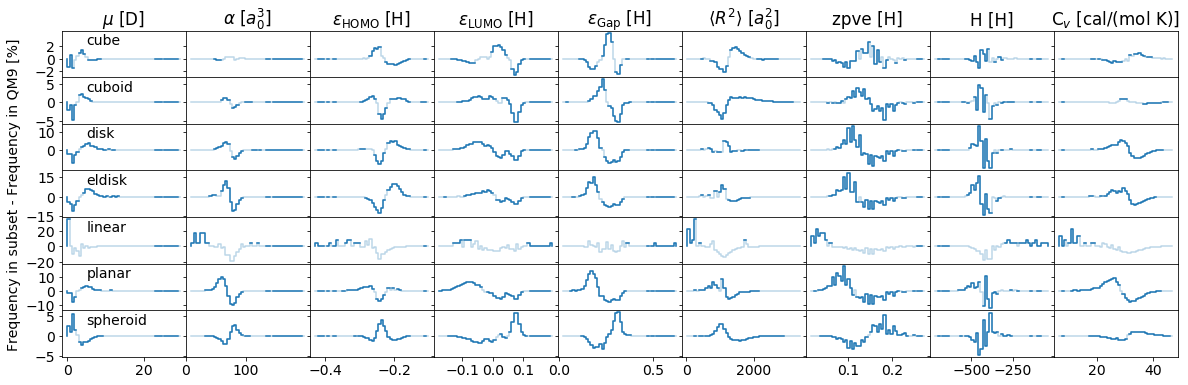

In [12]:
relevant_properties = 'dipole polarizability homo lumo gap extent zpve enthalpy heatcap'.split()
PROPLABELS={'dipole': r'$\mu$ [D]', 'polarizability': r'$\alpha$ [$a_0^3$]', 'homo': r'$\epsilon_\mathrm{HOMO}$ [H]', 'lumo': r'$\epsilon_\mathrm{LUMO}$ [H]', 'gap': r'$\epsilon_\mathrm{Gap}$ [H]', 'extent': r'$\langle R^2\rangle$ [$a_0^2$]',
           'zpve': 'zpve [H]', 'internalzero': r'U$_0$ [H]', 'internalfinite': r'U [H]', 'enthalpy': r'H [H]', 'freeenergy': r'G [H]', 'heatcap': r'C$_v$ [cal/(mol K)]'}
relevant_shapes = 'cube cuboid disk eldisk linear planar spheroid'.split()
f, axs = plt.subplots(len(relevant_shapes), len(relevant_properties), figsize=(20, 6), sharex='col', sharey='row')
for shapeid, shape in enumerate(relevant_shapes):
    axs[shapeid, 0].annotate(s=shape, xy=(0.2, 0.7), xycoords='axes fraction', horizontalalignment='left')
    
    for propertyid, propertyvalue in enumerate(relevant_properties):
        if shape == 'spheroid':
            try:
                axs[0, propertyid].set_title(PROPLABELS[propertyvalue])
            except:
                print (PROPLABELS[propertyvalue])
                raise
        plot_into_count(axs[shapeid, propertyid], propertyvalue, shape)

axs[3, 0].set_ylabel('Frequency in subset - Frequency in QM9 [%]')
axs[relevant_shapes.index('cube'), 0].set_yticks([ -2, 0, 2, ])
axs[relevant_shapes.index('cuboid'), 0].set_yticks([ -5, 0, 5, ])
axs[relevant_shapes.index('disk'), 0].set_yticks([  0, 10, ])
axs[relevant_shapes.index('eldisk'), 0].set_yticks([ -15, 0, 15, ])
axs[relevant_shapes.index('linear'), 0].set_yticks([ -20, 0, 20, ])
axs[relevant_shapes.index('planar'), 0].set_yticks([ -10, 0, 10, ])
axs[relevant_shapes.index('spheroid'), 0].set_yticks([ -5, 0, 5, ])

axs[relevant_shapes.index('spheroid'), relevant_properties.index('polarizability')].set_xticks([ 0, 100 ])
axs[relevant_shapes.index('spheroid'), relevant_properties.index('lumo')].set_xticks([ -0.1, 0, 0.1 ])
for col in 'enthalpy'.split():
    axs[relevant_shapes.index('spheroid'), relevant_properties.index(col)].set_xticks([ -500, -250 ])
plt.subplots_adjust(wspace=0.0, hspace=0.0)
plt.savefig('propertygridreduced.pdf', bbox_inches='tight')

In [34]:
# bias search, also in combined probabilities
# faster than any energy evaluation
# materials discovery, design
# even similar shapes can be of different distribution
# explain some of them, remaining ones are of interest to discover structure-function relationships
# descriptors in cheminformatics, classification criteria in ML
# discuss all properties and their possible link to shape

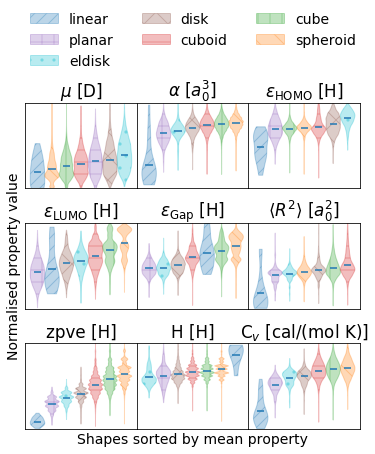

In [127]:
relevant_properties = 'dipole polarizability homo lumo gap extent zpve enthalpy heatcap'.split()
fig, axs = plt.subplots(3,3,sharex=True, sharey=True, figsize=(6, 6))
axs = np.ravel(axs)
colors = {'linear': '#1f77b4', 'spheroid': '#ff7f0e', 'cube':'#2ca02c', 'cuboid': '#d62728', 'planar': '#9467bd', 'disk': '#8c564b', 'eldisk':'#17becf'}
hatches = {'linear': '//', 'spheroid': '\\', 'cube':'|', 'cuboid': '-', 'planar': '+', 'disk': 'x', 'eldisk':'.'}
for idx, prop in enumerate(relevant_properties):
    ax = axs[idx]
    
    alldata = df[prop]
    minval, maxval = np.percentile(alldata, 0), np.percentile(alldata, 99.8)
    ax.set_ylim(0,1)
    
    labels = []
    ds = []
    means = []
    for name, group in df.groupby('shape'):
        series = group[prop].values
        series -= minval
        series /= (maxval - minval)
        series = series[(series > 0) & (series < 1)]
        labels.append(name)
        means.append(np.mean(series))
        ds.append(series)
    order = np.argsort(means)
    labels = np.array(labels)[order]
    ds = np.array(ds)[order]
    res = ax.violinplot(ds,showmeans=True, showextrema=False, widths=1)
    for lidx in range(len(labels)):
        res['bodies'][lidx].set_color(colors[labels[lidx]])
        res['bodies'][lidx].set_hatch(hatches[labels[lidx]])
    
    ax.set_title(PROPLABELS[prop])
    ax.set_xticks([])
    ax.set_yticks([])
axs[1].legend(res['bodies'], labels, ncol=3, frameon=False, bbox_to_anchor=(0.5, 2.2, ), loc='upper center')
axs[3].set_ylabel('Normalised property value')
axs[7].set_xlabel('Shapes sorted by mean property')
plt.subplots_adjust(wspace=0.0, hspace=0.4)
plt.savefig('ordering.png', bbox_inches='tight', dpi=600)